## **Autoencoders**

Autoencoders are a class of Generative Models that learn a lower dimensional feature representation from data. The architecture consists of an **Encoder** and a **Decoder**.

Encoder learns mapping from input data **${x}$**, to a lower dimensional latent space **${z}$**. On the other hand, Decoder tries to reconstruct **$\hat{x}$** by sampling from latent space. 

![](ae.png)

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.distributions import Normal
from torch.distributions.kl import kl_divergence
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision.utils import make_grid

import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

## **Loading and Visualizing Dataset**

In [2]:
def show(images, n_images, nrows, title, figsize):
  plt.figure(figsize=([figsize, figsize]))
  grid = make_grid(images.detach().cpu()[:n_images], nrow=nrows).permute(1,2,0).squeeze()
  plt.title(title)
  plt.axis('off')
  plt.imshow(grid)
  plt.show()

In [6]:
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [34]:
dataset = datasets.FashionMNIST('FashionMNIST', train=True,
                         transform=transform, download=True)
data_loader = DataLoader(dataset, batch_size=128,
                         shuffle=True)

In [8]:
for i, image in enumerate(data_loader):
  img = image[0]

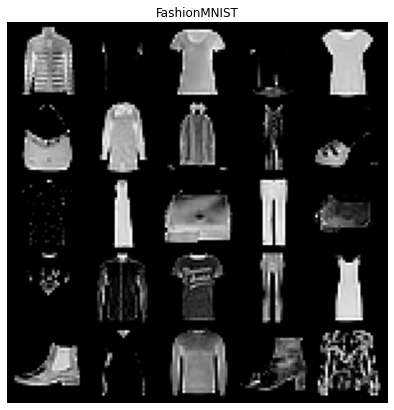

In [9]:
show(img, 25, 5, 'FashionMNIST', 7)

## **Encoder**

In [10]:
def encoder_block(input, output, kernel_size=4, stride=2, last_layer=False):
  if not last_layer:
    x = nn.Sequential(
        nn.Conv2d(input, output, kernel_size, stride),
        nn.BatchNorm2d(output),
        nn.LeakyReLU(0.2, inplace=True)
    )
  else:
    x = nn.Sequential(
        nn.Conv2d(input, output, kernel_size, stride)
    )
  return x

In [11]:
class Encoder(nn.Module):
  def __init__(self, image_dim, hidden_dim, z_dim):
    super(Encoder, self).__init__()
    self.z_dim = z_dim # Latent Space
    self.encoder = nn.Sequential(
        encoder_block(image_dim, hidden_dim),
        encoder_block(hidden_dim, hidden_dim * 2),
        encoder_block(hidden_dim * 2, z_dim * 2, last_layer=True)
    )
  
  def forward(self, image):
    encoded_pred = self.encoder(image)
    encoding = encoded_pred.view(len(encoded_pred), -1)
    return encoding[:, :self.z_dim], encoding[:, self.z_dim:].exp()

## **Decoder**

In [12]:
def decoder_block(input, output, kernel_size=3, stride=2, last_layer=False):
  if not last_layer:
    x = nn.Sequential(
        nn.ConvTranspose2d(input, output, kernel_size, stride),
        nn.BatchNorm2d(output),
        nn.ReLU(inplace=True)
    )
  else:
    x = nn.Sequential(
        nn.ConvTranspose2d(input, output, kernel_size, stride),
        nn.Sigmoid()
    )
  return x

In [13]:
class Decoder(nn.Module):
  def __init__(self, z_dim, hidden_dim, image_dim):
    super(Decoder, self).__init__()
    self.z_dim = z_dim
    self.decoder = nn.Sequential(
        decoder_block(z_dim, hidden_dim * 4),
        decoder_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
        decoder_block(hidden_dim * 2, hidden_dim),
        decoder_block(hidden_dim, image_dim, kernel_size=4, last_layer=True)
    )
  
  def forward(self, z_sample):
    return self.decoder(z_sample.view(len(z_sample), self.z_dim, 1, 1))

## **Variational Autoencoder - VAE**

VAE is a derivation of autoencoder. It learns a better and smoother representation of the data by introducing element of stochasticity to generate new data(images). unlike a traditional AE, VAE imposes a constraint on the latent distribution by forcing it to be a Normal distribution.

![](vae.png)

In [14]:
from matplotlib.colors import Normalize
class VAE(nn.Module):
  def __init__(self, image_dim, hidden_dim, z_dim):
    super(VAE, self).__init__()
    self.z_dim = z_dim
    self.encode = Encoder(image_dim, hidden_dim, z_dim)
    self.decode = Decoder(z_dim, hidden_dim, image_dim)
  
  def forward(self, image):
    q_mean, q_stddev = self.encode(image)
    q_dist = Normal(q_mean, q_stddev)
    z_sample = q_dist.rsample()
    decoded = self.decode(z_sample)
    return decoded, q_dist

## **Reconstruction Loss**

Reconstruction Loss is the distance between the images that is the input of Encoder and the image generated from the Decoder. It is defined as: $\mathbb{E}\left(\log p(x|z)\right)$

In [15]:
r_loss = nn.BCELoss(reduction='sum')

## **KL Divergence**

KL divergence is used to find out how different one distribution is from another. For example, if two distribution are same then their KL divergence value will be 0. In other words, it is a divergence between two distributions It is defined as: $\mathrm{D_{KL}}(q(z|x)\Vert p(z))$

In [16]:
def KLDivergence_loss(q_dist):
  kl_div = kl_divergence(q_dist, Normal(torch.zeros_like(q_dist.mean), torch.ones_like(q_dist.stddev))).sum(-1)
  return kl_div

## **Training**

In [17]:
image_dim = 1
hidden_dim = 64
z_dim = 32

device = 'cuda'
epochs = 100

In [18]:
vae = VAE(image_dim, hidden_dim, z_dim).to(device)
vae_optim = torch.optim.Adam(vae.parameters(), lr=0.002)

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 0
Loss: -1721357.125


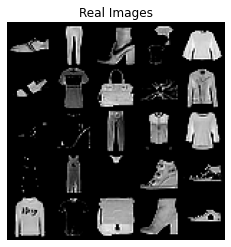

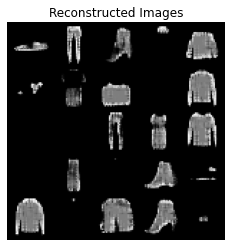

->0


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 10
Loss: -3383166.5


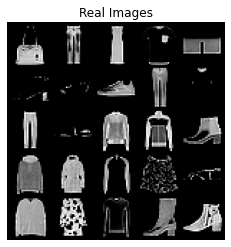

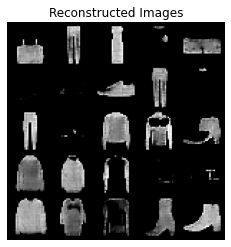

->10


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 20
Loss: -4204264.5


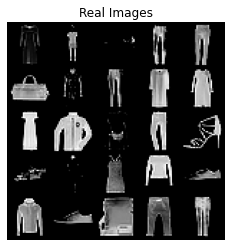

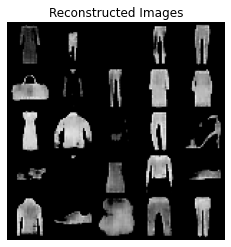

->20


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 30
Loss: -4428583.0


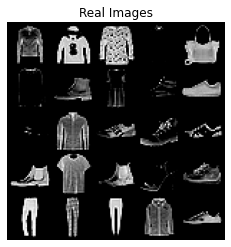

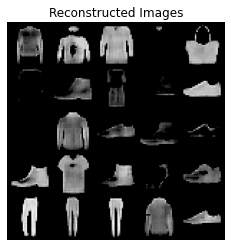

->30


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 40
Loss: -4273066.0


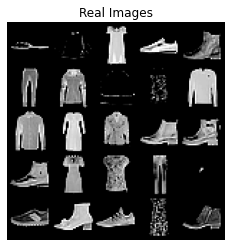

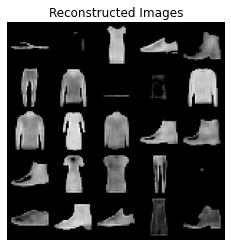

->40


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 50
Loss: -4523476.0


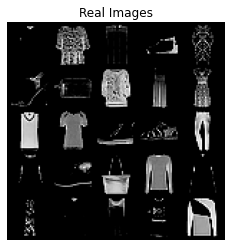

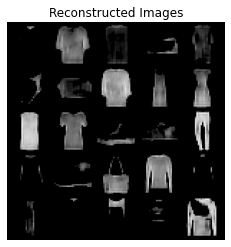

->50


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 60
Loss: -4281276.5


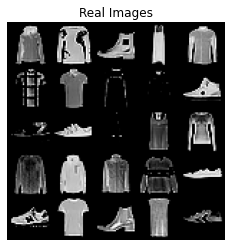

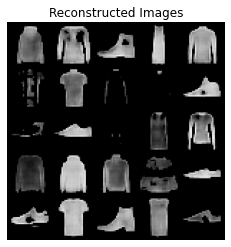

->60


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 70
Loss: -4231697.5


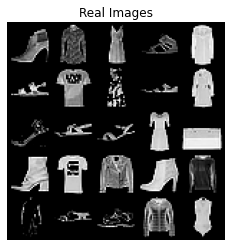

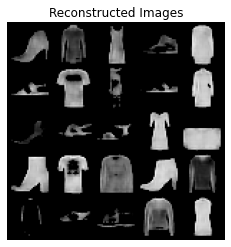

->70


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 80
Loss: -4410171.5


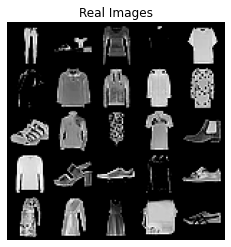

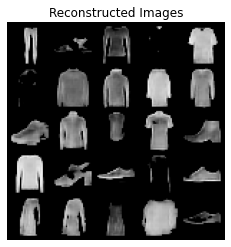

->80


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 90
Loss: -4448717.5


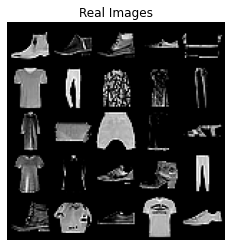

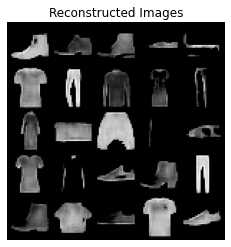

->90


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 100
Loss: -4543062.0


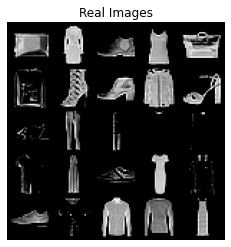

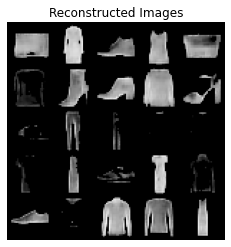

->100


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 110
Loss: -4428214.0


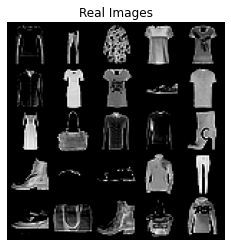

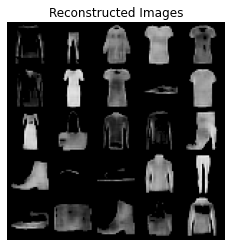

->q


In [19]:
loss = 0
# cond = ''
epoch = 0
for epoch in range(epochs):
# while cond != 'q':
  for image, _ in tqdm(data_loader):
    image = image.to(device)
    vae_optim.zero_grad()
    recon_image, encoding = vae(image)
    loss = r_loss(recon_image, image) + KLDivergence_loss(encoding).sum()
    loss.backward()
    vae_optim.step()
  if epoch % 10 == 0:
    print('Epoch {}\nLoss: {}'.format(epoch, loss))
    show(image, 25, 5, 'Real Images', 4)
    show(recon_image, 25, 5, 'Reconstructed Images', 4)
    # cond = input('->')
    torch.save(vae.state_dict(), 'vae_weights.pth')
  epoch += 1

In [20]:
vae.eval()

VAE(
  (encode): Encoder(
    (encoder): Sequential(
      (0): Sequential(
        (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.2, inplace=True)
      )
      (1): Sequential(
        (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.2, inplace=True)
      )
      (2): Sequential(
        (0): Conv2d(128, 64, kernel_size=(4, 4), stride=(2, 2))
      )
    )
  )
  (decode): Decoder(
    (decoder): Sequential(
      (0): Sequential(
        (0): ConvTranspose2d(32, 256, kernel_size=(3, 3), stride=(2, 2))
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (1): Sequential(
        (0): ConvTranspose2d(256, 128, kernel_size=(

In [33]:
# Uncomment for loading the pretrained weights
# vae.load_state_dict(torch.load('vae_weights.pth'))

## **Generating FashionMNIST samples**

In [21]:
for _, image in enumerate(data_loader):
  img = image[0]

In [29]:
idx = 10
image = img[idx:idx+16, ...].to(device)
print(image.size())
fake, _ = vae(image.detach())

torch.Size([16, 1, 28, 28])


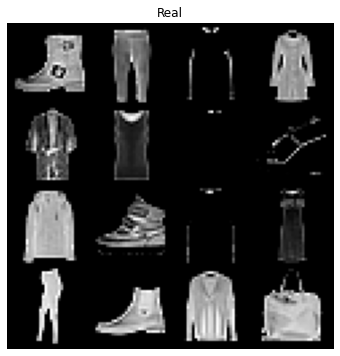

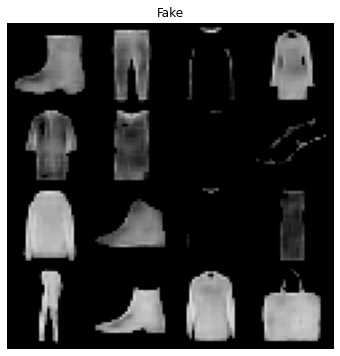

In [32]:
show(image, 16, 4, 'Real', 6)
show(fake, 16, 4, 'Fake', 6)